In [1]:
#Importing libraries
import numpy as np
from scipy import signal
from matplotlib import pyplot as plt
from matplotlib import mlab
import h5py
import glob
import os
import json
from scipy.interpolate import interp1d

#Variable to set the directory where LIGO data is
folderpath = '/Users/samsonmercier/Desktop/PHYS512/problem_sets/ps6/LOSC_Event_tutorial/'
os.chdir(folderpath)

In [2]:
#Define functions to get input
def read_template(filename):
    dataFile=h5py.File(filename,'r')
    template=dataFile['template']
    th=template[0]
    tl=template[1]
    return th,tl
def read_file(filename):
    dataFile=h5py.File(filename,'r')
    dqInfo = dataFile['quality']['simple']
    qmask=dqInfo['DQmask'][...]

    meta=dataFile['meta']
    gpsStart=meta['GPSstart'][()]
    utc=meta['UTCstart'][()]
    duration=meta['Duration'][()]
    strain=dataFile['strain']['Strain'][()]
    dt=(1.0*duration)/len(strain)

    dataFile.close()
    return strain,dt,utc

In [3]:
#Get the names of the files for both detectors
#and import the data from both files and the corresponding template
fname_h='H-H1_LOSC_4_V2-1128678884-32.hdf5'
fname_l='L-L1_LOSC_4_V2-1128678884-32.hdf5'
print('reading file ',fname_h)
strain_h,dt_h,utc_h=read_file(fname_h)
print('reading file ',fname_l)
strain_l,dt_l,utc_l=read_file(fname_l)

template_name='LVT151012_4_template.hdf5'
th,tl=read_template(template_name)

reading file  H-H1_LOSC_4_V2-1128678884-32.hdf5
reading file  L-L1_LOSC_4_V2-1128678884-32.hdf5


# A

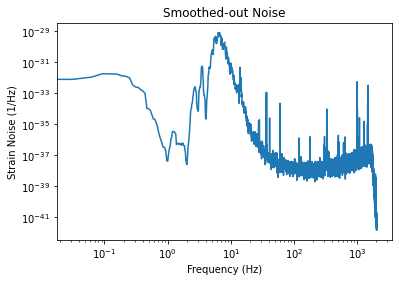

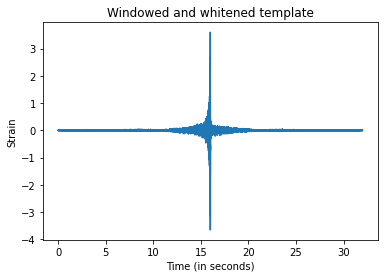

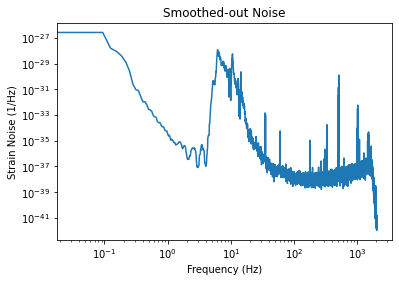

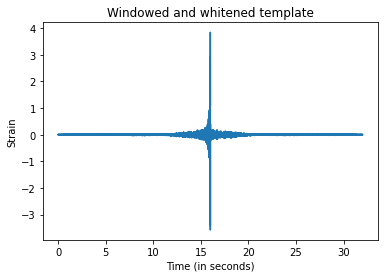

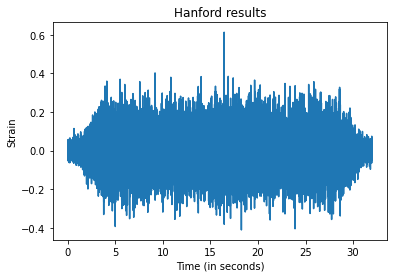

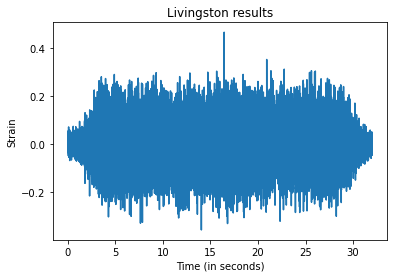

Numerical Signal-to-noise ratio for Hanford is:  10.396387237688106
Analytical Signal-to-noise ratio for Hanford is:  10.293291198748758
Numerical Signal-to-noise ratio for Hanford is:  8.840443922389147
Analytical Signal-to-noise ratio for Hanford is:  10.293288349957677


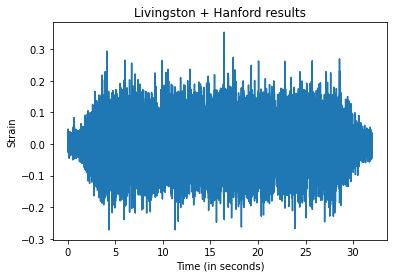

Numerical Signal-to-noise ratio for both detectors is:  9.005405120532304
Analytical Signal-to-noise ratio for both detectors is:  10.293286985886747


In [7]:
#Define our variables
N = len(strain_h)
a = 0.3

#Make an array of time and frequency values to figure out 
#for which frequency we have half the weight before and after.
x = np.linspace(0, 32, len(strain_h))
#We use the sampling rate provided in the .json file to find the
#increments in the frequency array.
f = np.fft.rfftfreq(x.size, 1/4096)

#Define window function
def window(alpha, N):
    return signal.windows.tukey(N, alpha)

#Get the window function for later.
win = window(a, N)

#Define our noise model function
def noise(template, strain):
    n_smooth = 6
    #Use the pre-defined window function to window our data and Fourier transform it
    win = window(a, N)
    sft = np.fft.rfft(win*strain)
    #Get our noise function
    Nft = np.abs(sft)**2
    #Smooth out our noise function with a convolution
    Nft = np.convolve(Nft, np.ones(n_smooth)/n_smooth, mode='same')
    #Whiten the Fourier transform of our signal and of our windowed templates
    sft_white = sft/np.sqrt(Nft)
    tft_white = np.fft.rfft(template*win)/np.sqrt(Nft)
    #Verifying we didn't mess up by looking at plots
    #Smoothed out noise
    plt.plot(f, np.abs(Nft))
    plt.title('Smoothed-out Noise')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Strain Noise (1/Hz)')
    plt.loglog()
    plt.show()
    #Windowed template
    plt.plot(x, np.fft.irfft(tft_white))
    plt.title('Windowed and whitened template')
    plt.xlabel('Time (in seconds)')
    plt.ylabel('Strain')
    plt.show()
    #Matched Filter Time
    xcorr = np.fft.irfft(sft_white*np.conj(tft_white))
    return xcorr, Nft, sft_white, tft_white

#Get the signal for Hanford detector
h, nft_h, sft_white_h, tft_white_h = noise(th, strain_h)

#Get the signal for Livingston detector
l, nft_l, sft_white_l, tft_white_l = noise(tl, strain_l)

#Plot the strain for both detectors to see if the signal is visible.
plt.plot(x, np.fft.fftshift(h))
plt.xlabel('Time (in seconds)')
plt.ylabel('Strain')
plt.title('Hanford results')
plt.show()

plt.plot(x, np.fft.fftshift(l))
plt.title('Livingston results')
plt.xlabel('Time (in seconds)')
plt.ylabel('Strain')
plt.show()

#Define functions to get SNR values both analytically and using the scatter
#in the plot. Details explaining how I chose these functions is outlined in the .txt file.
def scatter_SNR(h):
    Noiseratio = np.std(np.abs(h[10000:]))
    Signalratio = np.max(h[1700:1900])
    return Signalratio / Noiseratio

def analytic_SNR(win, th):
    X = np.abs(np.fft.irfft(np.fft.rfft(th*win) * np.conj(np.fft.rfft(th*win))))
    return np.max(X)/np.std(X[:5000])

print('Numerical Signal-to-noise ratio for Hanford is: ', scatter_SNR(h))
print('Analytical Signal-to-noise ratio for Hanford is: ', analytic_SNR(win, th))

print('Numerical Signal-to-noise ratio for Hanford is: ', scatter_SNR(l))
print('Analytical Signal-to-noise ratio for Hanford is: ', analytic_SNR(win, tl))

#Get the combined signal for the Livingston and Hanford events. 
#Get the corresponding SNR for this combined signal.
Comb = (l+h)/2
Comb_t = (th+tl)/2
plt.plot(x, np.fft.fftshift(Comb))
plt.xlabel('Time (in seconds)')
plt.ylabel('Strain')
plt.title('Livingston + Hanford results')
plt.show()

print('Numerical Signal-to-noise ratio for both detectors is: ', scatter_SNR(Comb))
print('Analytical Signal-to-noise ratio for both detectors is: ', analytic_SNR(win, Comb_t))

# E

In [5]:
#Get the fourier transform of our matched filtered signal.
hft = np.fft.rfft(h)
#Get the total area under the curve.
area = np.sum(np.abs(hft)*(f[1]-f[0]))
print('Total area is: ', area/2)
#Make a list that will contain the frequencies for which half the weight is before
# and half is after.
Correct_f=[]
#Iterate over all the frequencies
for i in range(1, len(f)):
    #Get the area under the curve up to the frequency we are considering.
    are = np.sum(np.abs(hft[:i]))*(f[1]-f[0])
    #Set a condition for when we are close to the target area.
    if np.abs(are-area/2)<5:
        Correct_f.append(f[i])
print('These are the frequencies that separate the weight evenly: ', Correct_f)

Total area is:  10482.333437596344
These are the frequencies that separate the weight evenly:  [113.15625, 113.1875, 113.21875]


# F

In [6]:
#From our combined signal, we extract the index at which we find the
#spike. Multiplying by dt we have the time of arrival of the gravitational wave.
#I have not calculated an error on this value but I assume we can get it from our
#noise model.
Comb = np.fft.fftshift(Comb)
ind = np.where(Comb==np.max(Comb))[0][0]
print('Time of arrival is: ', ind*dt_h, 'seconds')

Time of arrival is:  16.4423828125 seconds
